In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [2]:
# Data paths
TRAIN_PATH = '/kaggle/input/plant-dataset/plantsegv2/images/train'
TRAIN_MASK_PATH = '/kaggle/input/plant-dataset/plantsegv2/annotations/train'

VAL_PATH = '/kaggle/input/plant-dataset/plantsegv2/images/val'
VAL_MASK_PATH = '/kaggle/input/plant-dataset/plantsegv2/annotations/val'

TEST_PATH = '/kaggle/input/plant-dataset/plantsegv2/images/test'
TEST_MASK_PATH = '/kaggle/input/plant-dataset/plantsegv2/annotations/test'

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Function to load images and masks
def load_data(image_path, mask_path, img_height, img_width):
    images = []
    masks = []
    for image_name in sorted(os.listdir(image_path)):
        img = load_img(os.path.join(image_path, image_name), target_size=(img_height, img_width))
        images.append(img_to_array(img) / 255.0)  # Normalize images

    for mask_name in sorted(os.listdir(mask_path)):
        mask = load_img(os.path.join(mask_path, mask_name), target_size=(img_height, img_width), color_mode='grayscale')
        masks.append((img_to_array(mask) > 0).astype(np.float32))  # Binarize masks

    return np.array(images), np.array(masks)

# Load train, validation, and test datasets
x_train, y_train = load_data(TRAIN_PATH, TRAIN_MASK_PATH, IMG_HEIGHT, IMG_WIDTH)
x_val, y_val = load_data(VAL_PATH, VAL_MASK_PATH, IMG_HEIGHT, IMG_WIDTH)
x_test, y_test = load_data(TEST_PATH, TEST_MASK_PATH, IMG_HEIGHT, IMG_WIDTH)

print(f"Train data: {x_train.shape}, {y_train.shape}")
print(f"Validation data: {x_val.shape}, {y_val.shape}")
print(f"Test data: {x_test.shape}, {y_test.shape}")

Train data: (7916, 128, 128, 3), (7916, 128, 128, 1)
Validation data: (1247, 128, 128, 3), (1247, 128, 128, 1)
Test data: (2295, 128, 128, 3), (2295, 128, 128, 1)


In [3]:

print(f"Train data: {x_train.shape}, {y_train.shape}")
print(f"Validation data: {x_val.shape}, {y_val.shape}")
print(f"Test data: {x_test.shape}, {y_test.shape}")

Train data: (7916, 128, 128, 3), (7916, 128, 128, 1)
Validation data: (1247, 128, 128, 3), (1247, 128, 128, 1)
Test data: (2295, 128, 128, 3), (2295, 128, 128, 1)


In [4]:
from tensorflow.keras import layers, regularizers, Model, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras.layers import DepthwiseConv2D

def sep_conv_block(x, filters, l2_lambda=1e-4):
    """Depthwise separable convolution block."""
    x = DepthwiseConv2D(kernel_size=3, padding="same", depth_multiplier=1)(x)
    x = layers.Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(
        filters,
        (1, 1),
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
        padding="same",
    )(x)
    return x

def bifpn_block(inputs, filters, l2_lambda=1e-4):
    """A single BiFPN block with weighted feature fusion."""
    _, target_h, target_w, _ = inputs[0].shape  # Target shape is the first input

    aligned_inputs = []
    for feature in inputs:
        _, h, w, _ = feature.shape
        if h != target_h or w != target_w:
            aligned_feature = layers.Resizing(target_h, target_w, interpolation='bilinear')(feature)
            aligned_feature = layers.Conv2D(filters, (1, 1), padding="same")(aligned_feature)
            aligned_inputs.append(aligned_feature)
        else:
            aligned_inputs.append(layers.Conv2D(filters, (1, 1), padding="same")(feature))

    fused_features = []
    for feature in aligned_inputs:
        fused_features.append(sep_conv_block(feature, filters, l2_lambda))

    return layers.Add()(fused_features)

def unet_with_bifpn(input_shape=(128, 128, 3), l2_lambda=1e-4):
    inputs = Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Dropout(0.1)(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Dropout(0.1)(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Dropout(0.2)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.2)(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.3)(c5)

    # Decoder
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    up6 = layers.concatenate([up6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(up6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    up7 = layers.concatenate([up7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    up8 = layers.concatenate([up8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    up9 = layers.concatenate([up9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    
    #Apply Bifpn before the last layer
    bifpn_inputs = [c9, c8, c7, c6, c5]
    bifpn_features = bifpn_block(bifpn_inputs, filters=64, l2_lambda=l2_lambda)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(bifpn_features)

    model = Model(inputs, outputs)
    return model

# Example usage:
input_shape = (128, 128, 3)
model = unet_with_bifpn(input_shape=input_shape)

# Compile the model
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])  # num_classes should be 2 for binary

# Print Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_4… │
├──────────────────────

 Total params: 28,086,593 (107.14 MB)

 Trainable params: 28,078,017 (107.11 MB)

 Non-trainable params: 8,576 (33.50 KB)

In [5]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=150, batch_size=8, validation_data=(x_val,y_val), callbacks=[reduce_lr, early_stopping], verbose=1)


Epoch 1/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 424s 378ms/step - accuracy: 0.7700 - loss: 0.5509 - mean_io_u: 0.2987 - val_accuracy: 0.7203 - val_loss: 0.5350 - val_mean_io_u: 0.3983 - learning_rate: 0.0010
Epoch 2/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 325s 328ms/step - accuracy: 0.7981 - loss: 0.4523 - mean_io_u: 0.3012 - val_accuracy: 0.8046 - val_loss: 0.4337 - val_mean_io_u: 0.3983 - learning_rate: 0.0010
Epoch 3/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 325s 329ms/step - accuracy: 0.8055 - loss: 0.4366 - mean_io_u: 0.3006 - val_accuracy: 0.8170 - val_loss: 0.4508 - val_mean_io_u: 0.3983 - learning_rate: 0.0010
Epoch 4/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 325s 328ms/step - accuracy: 0.8172 - loss: 0.4138 - mean_io_u: 0.3007 - val_accuracy: 0.8346 - val_loss: 0.3979 - val_mean_io_u: 0.3983 - learning_rate: 0.0010
Epoch 5/150
990/990 ━━━━━━━━━━━━━━━━━━━━ 325s 328ms/step - accuracy: 0.8228 - loss: 0.3992 - mean_io_u: 0.3005 - val_accuracy: 0.8354 - val_loss: 0.3781 - val_mean_io_u: 0.3983 - learning_rate: 0.

In [6]:
# Save

model.save('unet_with_BiFPN.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


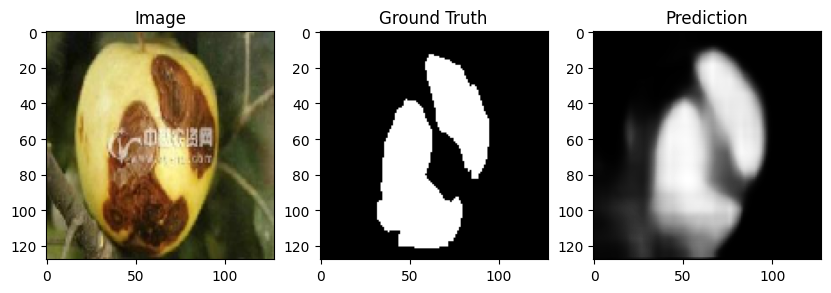

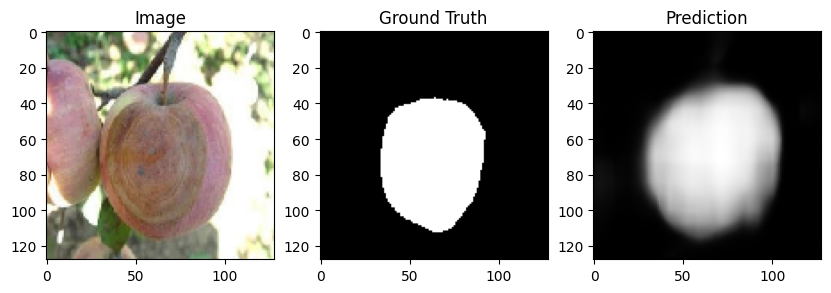

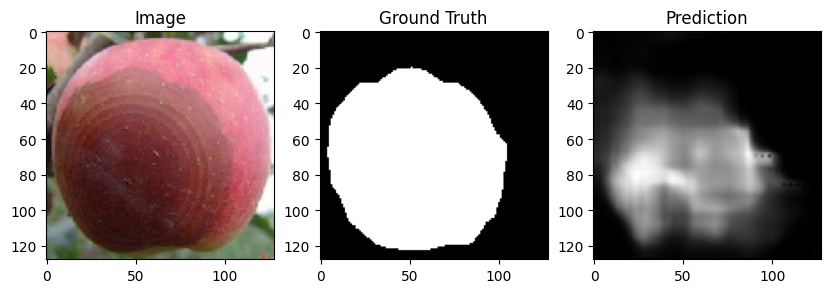

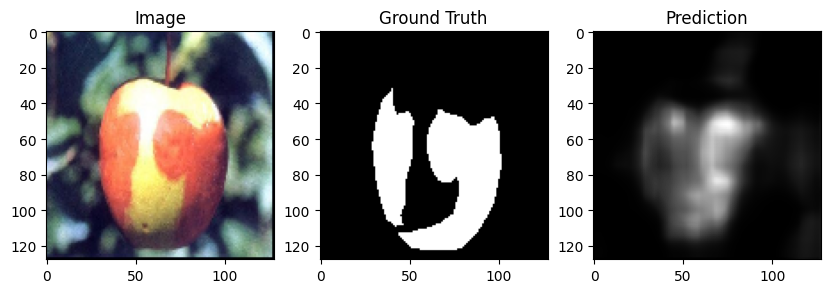

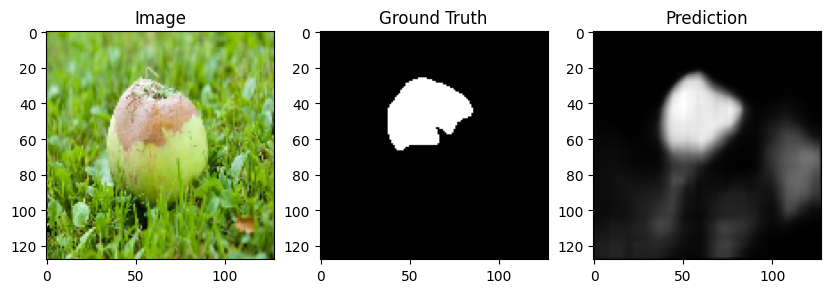

In [7]:
# Visualize predictions
def visualize_predictions(images, masks, model, n_samples=5):
    predictions = model.predict(images[:n_samples])
    for i in range(n_samples):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(images[i])

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(masks[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(predictions[i].squeeze(), cmap='gray')

        plt.show()

visualize_predictions(x_test, y_test, model)

In [8]:
# Custom metric: Mean Intersection Over Union (mIoU)
def mean_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.reduce_mean((intersection + 1e-7) / (union + 1e-7), axis=0)
    return iou

# Custom metric: Dice Coefficient
def dice_coefficient(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + 1e-7) / (tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) + 1e-7)
    return tf.reduce_mean(dice, axis=0)

# Custom metric: Pixel Accuracy
def pixel_accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    correct = tf.reduce_sum(tf.cast(y_true == y_pred, tf.float32), axis=[1, 2, 3])
    total = tf.cast(tf.size(y_true[0, :, :, 0]), tf.float32)
    accuracy = correct / total
    return tf.reduce_mean(accuracy, axis=0)

# Evaluate model and calculate metrics
def evaluate_model(model, x, y):
    preds = model.predict(x)
    iou = mean_iou(y, preds).numpy()
    dice = dice_coefficient(y, preds).numpy()
    accuracy = pixel_accuracy(y, preds).numpy()
    return iou, dice, accuracy

# Evaluate on each dataset
train_iou, train_dice, train_acc = evaluate_model(model, x_train, y_train)
val_iou, val_dice, val_acc = evaluate_model(model, x_val, y_val)
test_iou, test_dice, test_acc = evaluate_model(model, x_test, y_test)

print(f"Train - mIoU: {train_iou:.4f}, Dice: {train_dice:.4f}, Accuracy: {train_acc:.4f}")
print(f"Validation - mIoU: {val_iou:.4f}, Dice: {val_dice:.4f}, Accuracy: {val_acc:.4f}")
print(f"Test - mIoU: {test_iou:.4f}, Dice: {test_dice:.4f}, Accuracy: {test_acc:.4f}")

248/248 ━━━━━━━━━━━━━━━━━━━━ 160s 552ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 54s 759ms/step
Train - mIoU: 0.3824, Dice: 0.4971, Accuracy: 0.8581
Validation - mIoU: 0.3570, Dice: 0.4687, Accuracy: 0.8534
Test - mIoU: 0.3623, Dice: 0.4736, Accuracy: 0.8513


In [9]:
# Overlay segmentation mask on image
def overlay_mask(image, mask, alpha=0.4, color=(0, 1, 0)):
    overlay = np.zeros_like(image)
    overlay[:, :, 1] = mask.squeeze() * color[1]  # Apply color to mask
    return np.clip(image + alpha * overlay, 0, 1)

# Identify good and bad examples
def find_examples(images, masks, preds, n_examples=3, threshold=0.7):
    ious = [mean_iou(np.expand_dims(true, 0), np.expand_dims(pred, 0)).numpy()
            for true, pred in zip(masks, preds)]
    sorted_indices = np.argsort(ious)  # Sort by IoU
    good_indices = sorted_indices[-n_examples:]  # Best IoUs
    bad_indices = sorted_indices[:n_examples]  # Worst IoUs
    return good_indices, bad_indices

72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 506ms/step


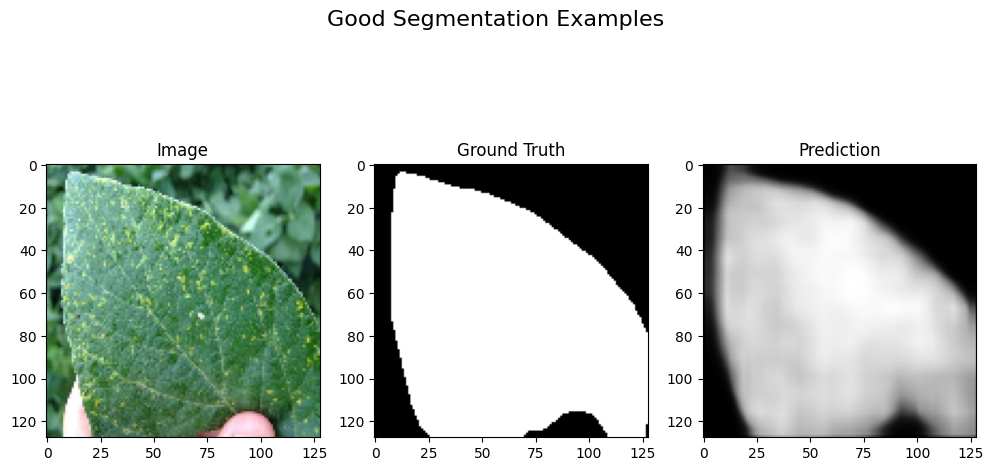

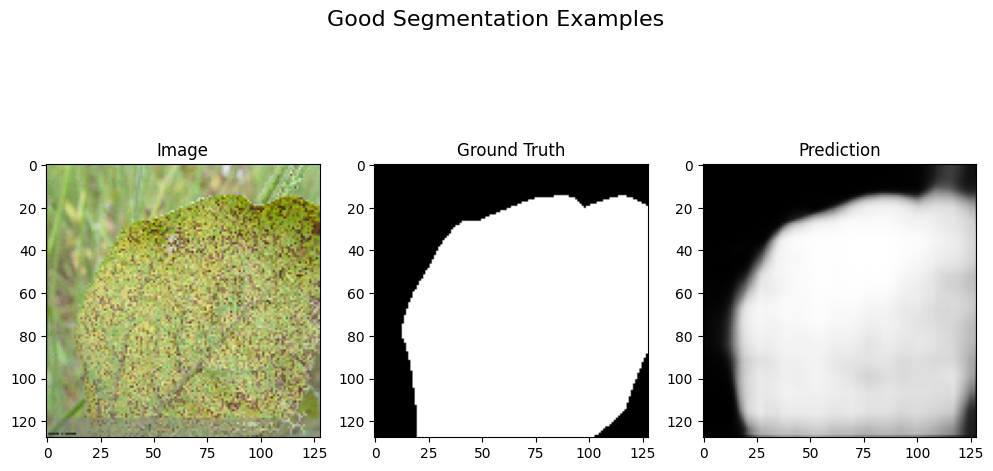

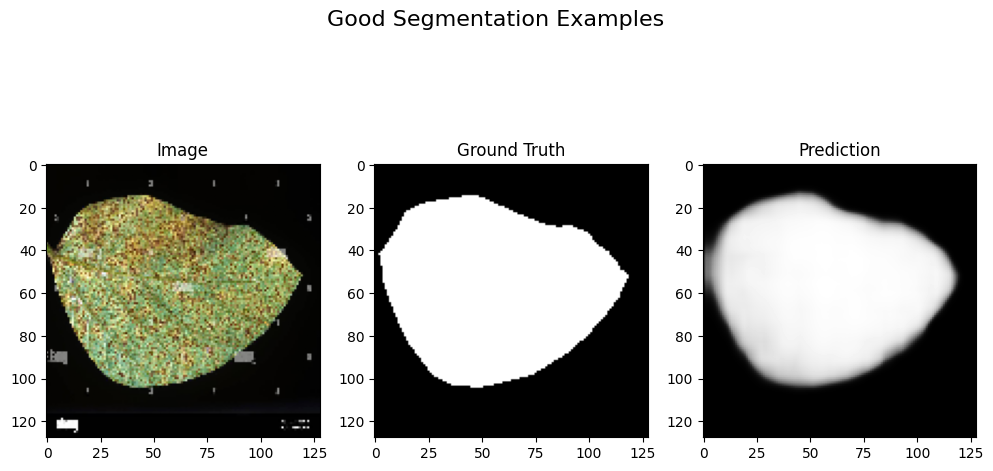

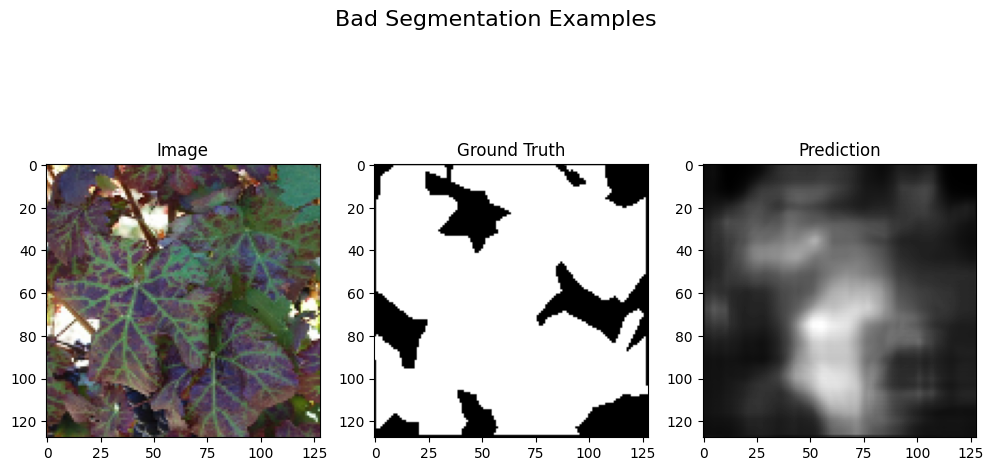

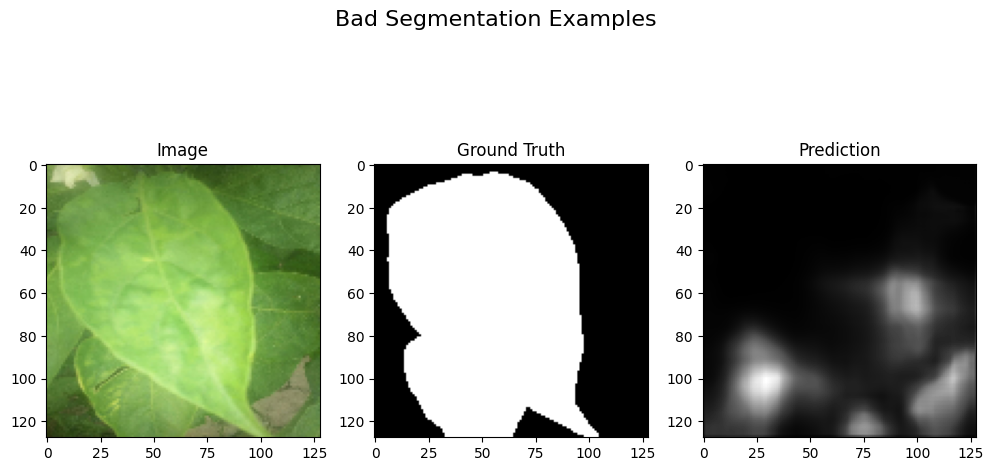

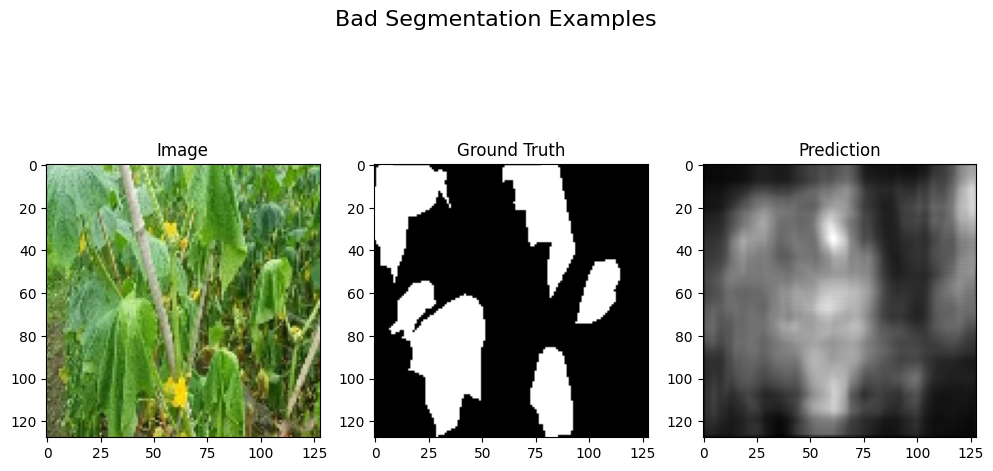

In [10]:
# Predictions
test_preds = model.predict(x_test)

# Find good and bad examples
good_indices, bad_indices = find_examples(x_test, y_test, test_preds, n_examples=3)

# Visualize examples
def visualize_examples(images, masks, preds, indices, title):
    for i in indices:
        plt.figure(figsize=(12, 6))
        plt.suptitle(title, fontsize=16)

        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(images[i])

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(masks[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(preds[i].squeeze(), cmap='gray')

        plt.show()

# Visualize good examples
visualize_examples(x_test, y_test, test_preds, good_indices, "Good Segmentation Examples")

# Visualize bad examples
visualize_examples(x_test, y_test, test_preds, bad_indices, "Bad Segmentation Examples")